In [1]:
import torch
import pytorch_lightning as pl

%matplotlib inline
import matplotlib.pyplot as plt

print(torch.__version__)

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)

from hydra.experimental import initialize, compose

from bliss import sleep
from bliss.datasets import simulated

import numpy as np

torch.manual_seed(84)
np.random.seed(43)

1.7.0


In [2]:
import sys
sys.path.insert(0, './m2_utils/')

import plotting
import m2_data
import summary_statistics

In [3]:
%env BLISS_HOME=/home/runingli/astronomy/celeste/

env: BLISS_HOME=/home/runingli/astronomy/celeste/


# Get config file

In [4]:
overrides = dict(
    model="m2",
    dataset="m2",
    training="m2",
)

overrides = [f"{key}={value}" for key, value in overrides.items()]

In [5]:
with initialize(config_path="../../config"):
    cfg = compose("config", overrides=overrides)

In [6]:
cfg.model.decoder.params.update({'ptile_padding': 6, 
                                 'max_sources': 5})

cfg.model.encoder.params.update({'max_detections': 2})

In [7]:
cfg

{'general': {'overwrite': False}, 'paths': {'root': '${env:BLISS_HOME}', 'output': 'logs/example'}, 'optimizer': {'name': 'torch.optim.Adam', 'params': {'lr': 0.0001, 'weight_decay': 1e-06}}, 'model': {'name': 'SleepPhase', 'image': {'slen': 100, 'n_bands': 2, 'background': [686.0, 1123.0]}, 'galaxy': {'slen': 51, 'latent_dim': 8}, 'decoder': {'params': {'n_bands': '${model.image.n_bands}', 'slen': '${model.image.slen}', 'tile_slen': 2, 'ptile_padding': 6, 'prob_galaxy': 0.0, 'n_galaxy_params': '${model.galaxy.latent_dim}', 'max_sources': 5, 'mean_sources': 0.48, 'min_sources': 0, 'f_min': 1000.0, 'f_max': 1000000.0, 'alpha': 0.5, 'gal_slen': '${model.galaxy.slen}', 'decoder_file': None, 'psf_params_file': '${paths.root}/data/sdss/2583/2/136/psField-002583-2-0136.fit', 'background_values': '${model.image.background}', 'border_padding': 3}}, 'encoder': {'params': {'n_bands': '${model.image.n_bands}', 'tile_slen': '${model.decoder.params.tile_slen}', 'ptile_slen': 8, 'max_detections': 2,

# Load dataset and encoder

In [8]:
dataset = simulated.SimulatedDataset(cfg)
sleep_net = sleep.SleepPhase(cfg, dataset)
trainer = pl.Trainer(**cfg.training.trainer)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


### Check priors

torch.Size([20, 2500])


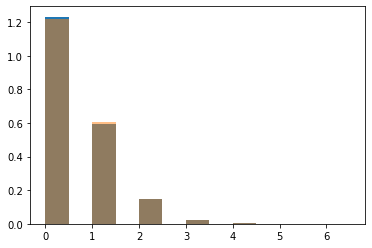

In [9]:
# prior on n-stars

%matplotlib inline

simulated_dataset = np.load('./old_prior_draw.npz')

print(dataset.get_batch()['n_stars'].shape)

plt.hist(dataset.get_batch()['n_stars'].flatten().cpu(), 
         bins=np.arange(7, step = 0.5), 
         density = True);

plt.hist(simulated_dataset['true_tile_n_sources'], 
         bins=np.arange(7, step = 0.5), 
         density = True, 
         alpha = 0.5);

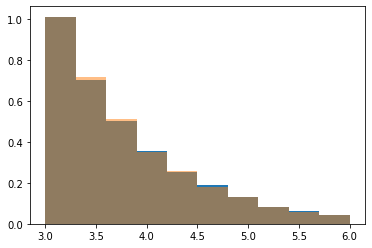

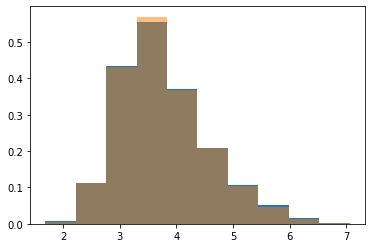

In [10]:
# prior on fluxes

%matplotlib inline

for b in range(2): 
    plt.figure()
    
    fluxes1 = dataset.get_batch()['fluxes'][:, :, :, b]
    fluxes1 = fluxes1.flatten()
    fluxes1 = fluxes1[fluxes1 > 0]

    fluxes2 = simulated_dataset['true_tile_fluxes'][:, :, b]
    fluxes2 = fluxes2.flatten()
    fluxes2 = fluxes2[fluxes2 > 0]


    bins = plt.hist(np.log10(fluxes1.cpu()), 
                     density = True)
    plt.hist(np.log10(fluxes2), 
                density = True, 
                bins = bins[1], 
                alpha = 0.5)


/home/runingli/anaconda3/envs/celeste_py/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/home/runingli/anaconda3/envs/celeste_py/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/home/runingli/anaconda3/envs/celeste_py/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in subtract
  del sys.path[0]


(array([0.00180858, 0.02017267, 0.14343462, 0.51447266, 0.91792607,
        0.87243322, 0.42223486, 0.10823679, 0.01391219, 0.00097385]),
 array([-1.6260526 , -1.2944442 , -0.9628359 , -0.6312275 , -0.29961914,
         0.03198922,  0.36359757,  0.6952059 ,  1.0268143 ,  1.3584226 ,
         1.690031  ], dtype=float32),
 <a list of 10 Patch objects>)

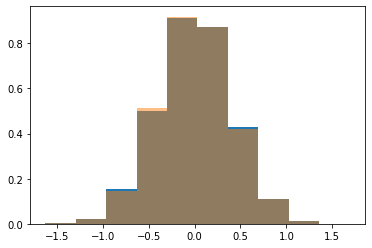

In [11]:
# prior on colors

%matplotlib inline

plt.figure()

fluxes1 = dataset.get_batch()['fluxes']
colors1 = (torch.log10(fluxes1[:, :, :, 1]) - 
           torch.log10(fluxes1[:, :, :, 0])).flatten()
colors1 = colors1[fluxes1[:, :, :, 0].flatten() > 0]

colors2 = np.log10(simulated_dataset['true_tile_fluxes'][:, :, 1]) - \
             np.log10(simulated_dataset['true_tile_fluxes'][:, :, 0])
colors2 = colors2.flatten()
colors2 = colors2[simulated_dataset['true_tile_fluxes'][:, :, 0].flatten() > 0]

bins = plt.hist(colors1.cpu(), 
                 density = True)
plt.hist(colors2, 
            density = True, 
            bins = bins[1], 
            alpha = 0.5)


# Plot an example image

In [12]:
batch = dataset.get_batch()

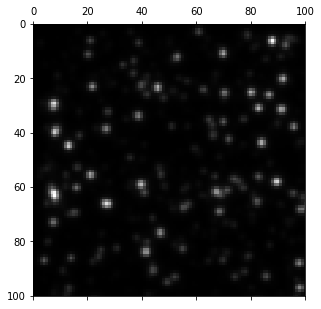

In [13]:
%matplotlib inline

image_indx = 0

image = batch['images'][image_indx, 0].cpu()

f, axarr = plt.subplots(1, 1, figsize=(5, 5))
plotting.plot_image(axarr, image)

In [14]:
image.shape

torch.Size([106, 106])

# Plot some subimages

In [15]:
slen = dataset.image_decoder.slen
border_padding = dataset.image_decoder.border_padding

In [16]:
# get locations on the full image
_, locs_full = sleep_net.image_encoder.get_full_params_from_sampled_params(slen, 
                                                            batch['n_sources'][0:1], 
                                                            batch['locs'][0:1])

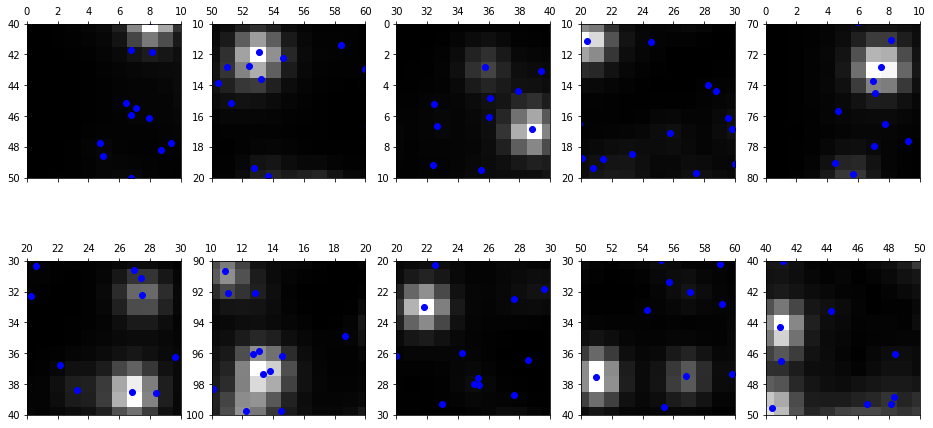

In [17]:
f, axarr = plt.subplots(2, 5, figsize=(16, 8))

subimage_slen = 10
indx_vec = np.arange(0, slen, subimage_slen)

for i in range(10): 
    x0 = np.random.choice(indx_vec)
    x1 = np.random.choice(indx_vec)
    
    ax = axarr[i // 5,  i % 5]
    
    plotting.plot_locations(locs_full.squeeze(), slen, border_padding, 
                            ax, marker = 'o', color = 'b')
    
    plotting.plot_image(ax, image, 
               x0, x1, subimage_slen, subimage_slen)


# Train!

In [18]:
# trainer.fit(sleep_net)
# torch.save(sleep_net.image_encoder.state_dict(), './starnet')

sleep_net.image_encoder.load_state_dict(torch.load('./starnet')); 

In [19]:
sleep_net.image_encoder.to(device);
sleep_net.image_encoder.eval();

# Plot results on simulated data

In [34]:
image_indx = 0

image = batch['images'][image_indx]
true_tile_n_stars = batch['n_stars'][image_indx]
true_tile_locs = batch['locs'][image_indx]
true_tile_fluxes = batch['fluxes'][image_indx]


# get locations on the full image (for plotting)
_, true_full_locs, true_full_fluxes = \
    sleep_net.image_encoder.get_full_params_from_sampled_params(slen, 
                                                            true_tile_n_stars.unsqueeze(0), 
                                                            true_tile_locs.unsqueeze(0), 
                                                            true_tile_fluxes.unsqueeze(0))

nelec_per_nmgy = 856.

In [35]:
# get map estiamates
map_nstars, map_locs, _, map_fluxes, _ = sleep_net.image_encoder.map_estimate(image.unsqueeze(0))

map_nstars = map_nstars.detach()
map_locs = map_locs.detach()
map_fluxes = map_fluxes.detach()

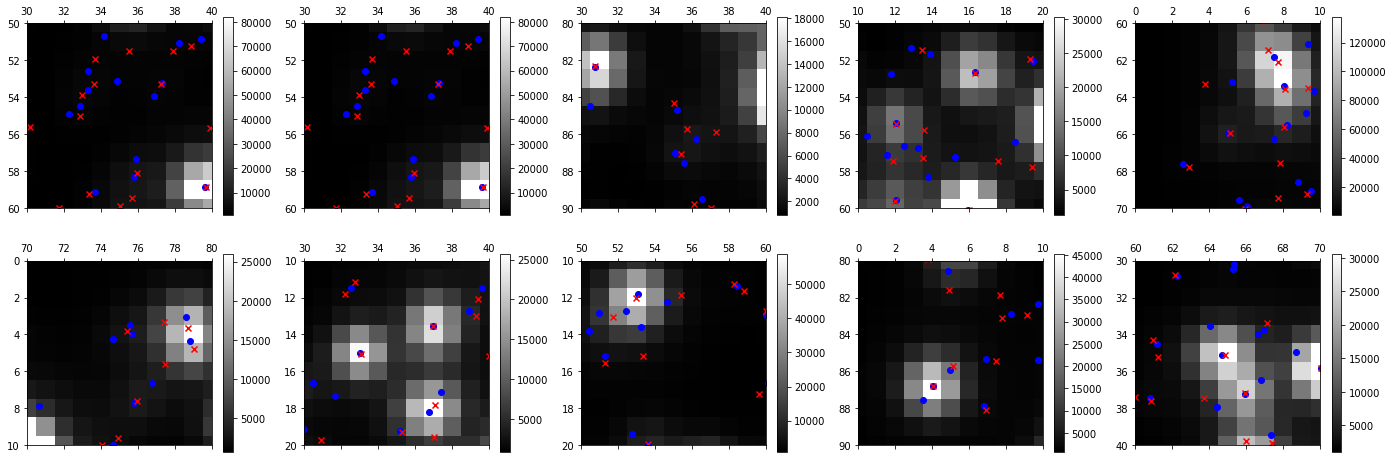

In [36]:
f, axarr = plt.subplots(2, 5, figsize=(24, 8))

subimage_slen = 10
indx_vec = np.arange(0, slen, subimage_slen)

for i in range(10): 
    x0 = np.random.choice(indx_vec)
    x1 = np.random.choice(indx_vec)
    
    ax = axarr[i // 5,  i % 5]
    
    plotting.plot_locations(true_full_locs.squeeze(), slen, border_padding, 
                            ax, marker = 'o', color = 'b')
    plotting.plot_locations(map_locs.squeeze(), slen, border_padding, 
                            ax, marker = 'x', color = 'red')
    
    im = plotting.plot_image(ax, image[0], 
               x0, x1, subimage_slen, subimage_slen)
    
    f.colorbar(im, ax = ax)

In [37]:
summary_statistics.get_summary_stats(map_locs.squeeze().cpu(), 
                            true_full_locs[0].cpu(), 
                            slen, 
                            map_fluxes.exp()[0, :, 0].cpu(), 
                            true_full_fluxes[0, :, 0].cpu(),
                            nelec_per_nmgy)[0:2]

(tensor(0.3932), tensor(0.4659))

(array([ 15., 193., 278., 211., 105.,  64.,  49.,  40.,  28.,  20.]),
 array([2.7758012, 3.1027122, 3.4296231, 3.7565339, 4.083445 , 4.4103556,
        4.7372665, 5.0641775, 5.3910885, 5.7179995, 6.0449104],
       dtype=float32),
 <a list of 10 Patch objects>)

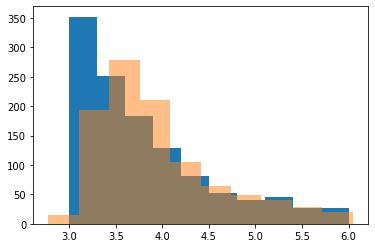

In [38]:
# flux distributions
plt.hist(torch.log10(true_full_fluxes[0, :, 0].cpu()))
plt.hist(torch.log10(map_fluxes.exp()[0, :, 0].cpu()), alpha = 0.5)

# plot results on SDSS data

In [39]:
sdss_image, _, hubble_locs, hubble_fluxes, sdss_data, _ = \
    m2_data.load_m2_data(sdss_dir = '../../data/sdss/',
                        hubble_dir = '../../data/hubble/', 
                        border_padding = border_padding)

nelec_per_nmgy = sdss_data[0]['nelec_per_nmgy'][0].mean()

loading sdss image from ../../data/sdss/2583/2/136/frame-r-002583-2-0136.fits
loading sdss image from ../../data/sdss/2583/2/136/frame-i-002583-2-0136.fits
loading hubble data from  ../../data/hubble/hlsp_acsggct_hst_acs-wfc_ngc7089_r.rdviq.cal.adj.zpt
getting sdss coordinates from:  ../../data/sdss/2583/2/136/frame-r-002583-2-0136.fits

 aligning images. 
 Getting sdss coordinates from:  ../../data/sdss/2583/2/136/frame-i-002583-2-0136.fits

 returning image at x0 = 630, x1 = 310


In [40]:
sdss_image.shape

torch.Size([2, 106, 106])

In [41]:
use_simulated_data = False

In [42]:
if use_simulated_data: 
    
    # convert to tile parameterization
    tile_coords = plotting._get_tile_coords(slen = 100, 
                                 tile_slen = 2)

    hubble_tile_locs, hubble_tile_fluxes, hubble_tile_nstars, _  = \
        plotting.get_params_in_tiles(tile_coords, 
                                        hubble_locs.unsqueeze(0), 
                                        hubble_fluxes.unsqueeze(0), 
                                        slen = 100,
                                        subimage_slen=2)
    max_stars = int(hubble_tile_nstars.max())
        
    # reshape 
    n_tiles = tile_coords.shape[0]
    _n_sources = hubble_tile_nstars.unsqueeze(0)
    _locs = hubble_tile_locs.unsqueeze(0)
    _galaxy_bool = torch.zeros(1, n_tiles, max_stars, 1, device = device)
    _galaxy_params = torch.zeros(1, n_tiles, max_stars, 8, device = device)
    _fluxes = hubble_tile_fluxes.unsqueeze(0)

    # simulate image
    image = dataset.image_decoder.render_images(
                                _n_sources,
                                _locs,
                                _galaxy_bool,
                                _galaxy_params,
                                _fluxes).detach()
else: 
    image = sdss_image.unsqueeze(0)

In [43]:
# get map estiamates
map_nstars, map_locs, _, map_fluxes, _ = sleep_net.image_encoder.map_estimate(image)

map_nstars = map_nstars.detach()
map_locs = map_locs.detach()
map_fluxes = map_fluxes.detach()

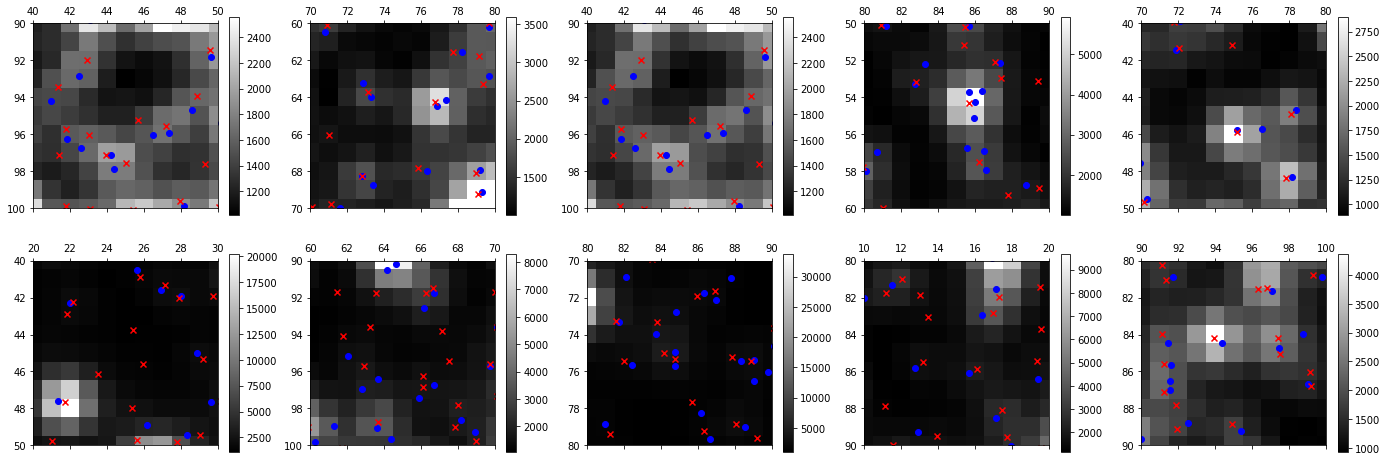

In [44]:
f, axarr = plt.subplots(2, 5, figsize=(24, 8))

subimage_slen = 10
indx_vec = np.arange(0, slen, subimage_slen)

for i in range(10): 
    x0 = np.random.choice(indx_vec)
    x1 = np.random.choice(indx_vec)
    
    ax = axarr[i // 5,  i % 5]
    
    plotting.plot_locations(hubble_locs, slen, border_padding, 
                            ax, marker = 'o', color = 'b')
    plotting.plot_locations(map_locs.squeeze(), slen, border_padding, 
                            ax, marker = 'x', color = 'red')
    
    im = plotting.plot_image(ax, image[0, 0], 
               x0, x1, subimage_slen, subimage_slen)
    
    f.colorbar(im, ax = ax)

In [45]:
summary_statistics.get_summary_stats(map_locs.squeeze().cpu(), 
                            hubble_locs.cpu(), 
                            slen, 
                            map_fluxes.exp()[0, :, 0].cpu(), 
                            hubble_fluxes[:, 0].cpu(),
                            nelec_per_nmgy)[0:2]

(tensor(0.3491), tensor(0.3136))

(array([ 31., 386., 470., 275.,  95.,  23.,  10.,   7.,   5.,   1.]),
 array([2.6957967, 3.038437 , 3.3810773, 3.7237175, 4.0663576, 4.408998 ,
        4.751638 , 5.0942783, 5.4369187, 5.7795587, 6.122199 ],
       dtype=float32),
 <a list of 10 Patch objects>)

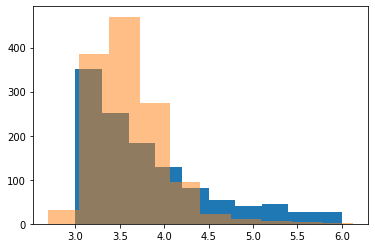

In [46]:
# flux distributions
plt.hist(torch.log10(true_full_fluxes[0, :, 0].cpu()))
plt.hist(torch.log10(map_fluxes.exp()[0, :, 0].cpu()), alpha = 0.5)